# Here I will build models trained to predict 2 groups of ROIs trained on either counts of different types of cells in that ROI, the transformed neighborhood data or a combination of the two

In [1]:
#### importing original data ####
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns 
import re 
%matplotlib inline
import glob
from tqdm import tqdm


In [7]:
# Load the test data
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)
X
# no distinguishing center cells


,tumor CD8 IFNg+ %,tumor Number of CD8s,tumor CD3 IFNg+ %,tumor Number of CD3s,tumor NK IFNg+ %,tumor Number of NKs,tumor Tumor cell MHC1+ %,tumor Number of Tumor cells,tumor CD8 act CD3+CD8+IFNy+ Tumor Neighbors_30um,tumor CD8 act CD3+CD8+IFNy+ Stroma Neighbors_30um,...,stroma MHC1- Tumor CD56+CD3-IFNy+ Tumor Neighbors_200um,stroma MHC1- Tumor CD56+CD3-IFNy+ Stroma Neighbors_200um,stroma MHC1- Tumor CD56+CD3-IFNy- Tumor Neighbors_200um,stroma MHC1- Tumor CD56+CD3-IFNy- Stroma Neighbors_200um,stroma MHC1- Tumor PanCyto+MHCI+ Tumor Neighbors_200um,stroma MHC1- Tumor PanCyto+MHCI+ Stroma Neighbors_200um,stroma MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um,stroma MHC1- Tumor PanCyto+MHCI- Stroma Neighbors_200um,survival group,patient
"17-199_[43424,7543]",0.000000,14.0,0.000000,176.0,0.000000,86.0,1.000000,514.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,< 3 years,17-199
"17-199_[43424,9043]",0.000000,228.0,0.000000,1758.0,0.000000,148.0,1.000000,718.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,< 3 years,17-199
"17-199_[44446,10543]",0.000000,1094.0,0.000000,6514.0,0.009036,664.0,0.996696,1816.0,0.000000,0.0,...,0.000000,0.000000,0.186693,0.272109,0.203616,0.188524,0.000000,0.475392,< 3 years,17-199
"17-199_[44675,12043]",0.000000,438.0,0.000000,2824.0,0.000000,212.0,1.000000,880.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,< 3 years,17-199
"17-199_[45431,7543]",0.000000,40.0,0.000000,164.0,0.000000,90.0,0.974359,234.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,< 3 years,17-199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"17-536_[47032,15356]",0.083333,84.0,0.024952,521.0,0.153846,13.0,0.437700,1565.0,0.679002,0.0,...,0.020584,0.009756,0.209875,0.326591,1.227182,0.814559,1.418455,0.787495,> 3 years,17-536
"17-536_[47032,16856]",0.025000,40.0,0.002688,372.0,0.666667,9.0,0.464430,1490.0,0.000000,0.0,...,0.147685,0.046826,0.093359,0.011914,1.111608,1.061430,1.379513,0.770417,> 3 years,17-536
"17-536_[49039,10345]",0.000000,34.0,0.000000,231.0,0.000000,21.0,0.233633,3116.0,0.000000,0.0,...,0.000000,0.000000,0.151573,0.057255,0.899263,0.491867,1.207914,0.359779,> 3 years,17-536
"17-536_[49039,11845]",0.000000,42.0,0.000000,248.0,0.000000,30.0,0.236631,3123.0,0.000000,0.0,...,0.000000,0.000000,0.156192,0.148743,0.814871,0.493070,1.165689,0.469212,> 3 years,17-536


# normalize the data 

# Model for counts only

In [8]:
counts_df = X[[col for col in X.columns if 'Number' in col or '%' in col or 'survival' in col or 'patient' in col]]
neighbors_df = X[[col for col in X.columns if 'Neighbors' in col or 'survival' in col or 'patient' in col]]
selected_columns = set(counts_df.columns).union(neighbors_df.columns)

# Find columns in X that are not in counts_df or neighbors_df
remaining_columns = [col for col in X.columns if col not in selected_columns]
counts_df

,tumor CD8 IFNg+ %,tumor Number of CD8s,tumor CD3 IFNg+ %,tumor Number of CD3s,tumor NK IFNg+ %,tumor Number of NKs,tumor Tumor cell MHC1+ %,tumor Number of Tumor cells,stroma CD8 IFNg+ %,stroma Number of CD8s,stroma CD3 IFNg+ %,stroma Number of CD3s,stroma NK IFNg+ %,stroma Number of NKs,stroma Tumor cell MHC1+ %,stroma Number of Tumor cells,survival group,patient
"17-199_[43424,7543]",0.000000,14.0,0.000000,176.0,0.000000,86.0,1.000000,514.0,0.000000,202.0,0.000000,2420.0,0.003311,604.0,1.000000,26.0,< 3 years,17-199
"17-199_[43424,9043]",0.000000,228.0,0.000000,1758.0,0.000000,148.0,1.000000,718.0,0.000000,760.0,0.000284,7050.0,0.000000,870.0,1.000000,110.0,< 3 years,17-199
"17-199_[44446,10543]",0.000000,1094.0,0.000000,6514.0,0.009036,664.0,0.996696,1816.0,0.000000,1438.0,0.000248,8054.0,0.000000,1206.0,0.963855,166.0,< 3 years,17-199
"17-199_[44675,12043]",0.000000,438.0,0.000000,2824.0,0.000000,212.0,1.000000,880.0,0.000000,532.0,0.000000,2994.0,0.006098,328.0,1.000000,76.0,< 3 years,17-199
"17-199_[45431,7543]",0.000000,40.0,0.000000,164.0,0.000000,90.0,0.974359,234.0,0.000000,790.0,0.000000,3410.0,0.000000,1994.0,1.000000,74.0,< 3 years,17-199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"17-536_[47032,15356]",0.083333,84.0,0.024952,521.0,0.153846,13.0,0.437700,1565.0,0.009091,110.0,0.000854,1171.0,0.040000,25.0,0.700880,341.0,> 3 years,17-536
"17-536_[47032,16856]",0.025000,40.0,0.002688,372.0,0.666667,9.0,0.464430,1490.0,0.010638,94.0,0.001554,1287.0,0.500000,4.0,0.833803,355.0,> 3 years,17-536
"17-536_[49039,10345]",0.000000,34.0,0.000000,231.0,0.000000,21.0,0.233633,3116.0,0.000000,24.0,0.000000,84.0,0.000000,8.0,0.760000,50.0,> 3 years,17-536
"17-536_[49039,11845]",0.000000,42.0,0.000000,248.0,0.000000,30.0,0.236631,3123.0,0.000000,17.0,0.000000,99.0,0.000000,12.0,0.740385,104.0,> 3 years,17-536


In [9]:
# LASSO select features

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from scipy import stats
from scipy.stats import zscore 

X = counts_df
y_str = X['survival group']
X = X.drop(columns=['survival group', 'patient'])
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
X = X.fillna(0)
X = stats.zscore(X, ddof = 1)
#X = np.log1p(X)


#z_score_x = zscore(X.astype(float), axis = 1, ddof=1)

# parameters to be tested on GridSearchCV


# Number of Folds and adding the random state for replication

# Initializing the Model
lassocv = LassoCV(alphas=[1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1],cv = 10)


# GridSearchCV with model, params and folds.
lassocv.fit(X,y)
lasso_feat = lassocv.coef_
selected_features = np.array(X.columns)[lasso_feat != 0]
lasso_selected_x = X.loc[:,X.columns.isin(selected_features)]

# warnings can be supressed by increasing n_iter


In [10]:
# print optimal alpha and number of features
print(lassocv.alpha_, sum(x != 0 for x in lassocv.coef_))

0.1 5


In [11]:
# filter to the lasso selected features
X = counts_df
y_str = X['survival group']
X = X.drop(columns=['survival group'])
X = X.loc[:,X.columns.isin(selected_features)]
X = stats.zscore(X, ddof = 0)
#X = np.log1p(X)
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
X

,tumor CD8 IFNg+ %,tumor Number of CD8s,tumor Tumor cell MHC1+ %,stroma CD8 IFNg+ %,stroma Tumor cell MHC1+ %
"17-199_[43424,7543]",-0.384582,-0.600091,2.592465,-0.230093,1.022578
"17-199_[43424,9043]",-0.384582,0.122891,2.592465,-0.230093,1.022578
"17-199_[44446,10543]",-0.384582,3.048605,2.581028,-0.230093,0.907838
"17-199_[44675,12043]",-0.384582,0.832360,2.592465,-0.230093,1.022578
"17-199_[45431,7543]",-0.384582,-0.512252,2.503711,-0.230093,1.022578
...,...,...,...,...,...
"17-536_[47032,15356]",0.170389,-0.363602,0.646119,-0.112095,0.073028
"17-536_[47032,16856]",-0.218091,-0.512252,0.738641,-0.092010,0.494989
"17-536_[49039,10345]",-0.384582,-0.532523,-0.060238,-0.230093,0.260704
"17-536_[49039,11845]",-0.384582,-0.505495,-0.049859,-0.230093,0.198435


100%|██████████| 1000/1000 [00:04<00:00, 231.43it/s]


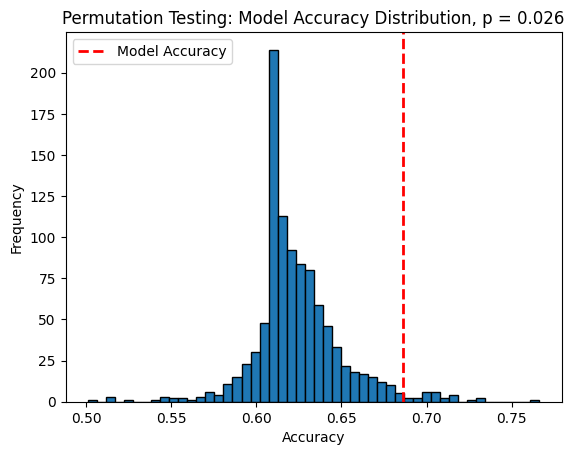

In [12]:
# build model with lasso selected features
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)







# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in tqdm(range(num_permutations)):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {round(p, 3)}')
plt.legend()

plt.show()

<Figure size 800x600 with 0 Axes>

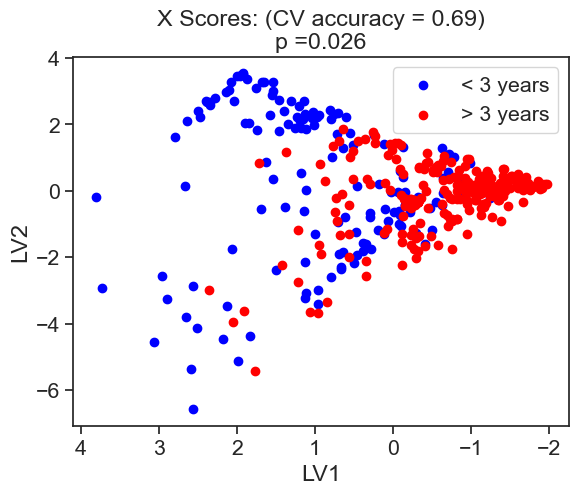

In [13]:
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho']) 
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(8, 6)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
fig, ax = plt.subplots()
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='< 3 years')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='> 3 years')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.xlabel('LV1')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.ylabel('LV2')
plt.legend(bbox_to_anchor = (1,1))
ax.invert_xaxis()
plt.show()

Text(0.5, 1.0, 'VIPs for oPLSDA model')

<Figure size 400x600 with 0 Axes>

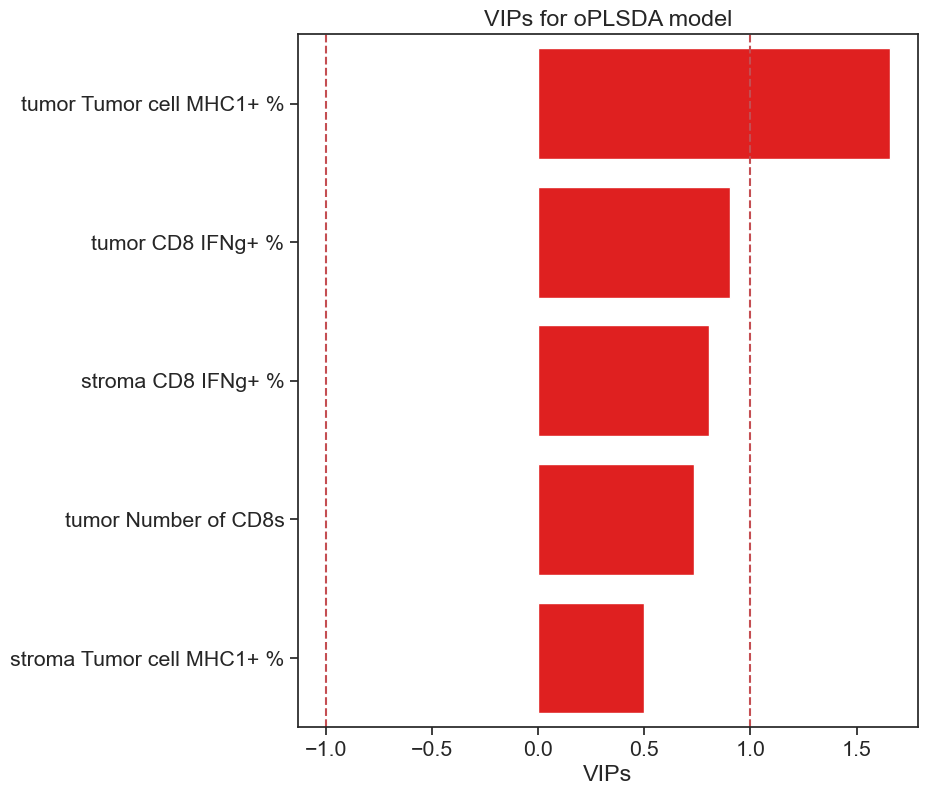

In [14]:

# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 
plt.figure(figsize=(8, 9)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] < 0, '> 3 years', '< 3 years')
colors = {'< 3 years': 'red', '> 3 years': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_VIPS.pdf',format='pdf', bbox_inches = 'tight')
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/fig6d_old_names.pdf', format = 'pdf', bbox_inches = 'tight')

plt.title('VIPs for oPLSDA model')

In [15]:
# Save CV accuracy
counts_cv = processed_accuracy_rounded

# Transformed Neighbor data only

In [17]:
# Lasso select features
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from scipy import stats
from scipy.stats import zscore 

X = neighbors_df
y_str = X['survival group']
X = X.drop(columns=['survival group', 'patient'])
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
X = X.fillna(0)
X = stats.zscore(X, ddof = 1)
#X = np.log1p(X)


#z_score_x = zscore(X.astype(float), axis = 1, ddof=1)

# parameters to be tested on GridSearchCV


# Number of Folds and adding the random state for replication

# Initializing the Model
lassocv = LassoCV(alphas=[1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1],cv = 10, max_iter=10000)


# GridSearchCV with model, params and folds.
lassocv.fit(X,y)
lasso_feat = lassocv.coef_
selected_features = np.array(X.columns)[lasso_feat != 0]
lasso_selected_x = X.loc[:,X.columns.isin(selected_features)]

# warnings can be supressed by increasing max_iter

/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e+00, tolerance: 3.046e-02
  model = cd_fast.enet_coordinate_descent(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.732e+00, tolerance: 3.046e-02
  model = cd_fast.enet_coordinate_descent(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

In [18]:
# print alpha and number of features
print(lassocv.alpha_, sum(x != 0 for x in lassocv.coef_))

0.1 11


In [19]:
# filter to the lasso selected features
X = neighbors_df
y_str = X['survival group']
X = X.drop(columns=['survival group'])
X = X.loc[:,X.columns.isin(selected_features)]
X = stats.zscore(X, ddof = 0)
#X = np.log1p(X)
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
X


,tumor MHC1+ Tumor PanCyto+MHCI+ Tumor Neighbors_30um,tumor MHC1- Tumor PanCyto+MHCI- Stroma Neighbors_30um,tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um,stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_30um,stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um,stroma NK act CD56+CD3-IFNy+ Stroma Neighbors_30um,stroma NK inact CD56+CD3-IFNy- Stroma Neighbors_200um,stroma NK inact PanCyto+MHCI- Tumor Neighbors_200um,stroma MHC1+ Tumor CD3+CD8-IFNy+ Stroma Neighbors_30um,stroma MHC1+ Tumor PanCyto+MHCI- Tumor Neighbors_200um,stroma MHC1- Tumor PanCyto+MHCI- Stroma Neighbors_30um
"17-199_[43424,7543]",-0.110275,-0.403339,-1.430154,-0.590652,-0.044032,3.853918,0.936115,-0.952534,-0.245774,-1.106273,-0.658261
"17-199_[43424,9043]",-0.519780,-0.403339,-1.430154,-0.690035,-0.317455,-0.298584,0.152274,-0.952534,-0.245774,-1.106273,-0.658261
"17-199_[44446,10543]",-0.724039,-0.403339,-0.368426,-0.709606,-0.410577,-0.298584,0.100949,-0.936888,-0.245774,-1.029689,0.857163
"17-199_[44675,12043]",-0.354390,-0.403339,-1.430154,-0.556519,0.004377,3.853918,1.010153,-0.952534,-0.245774,-1.106273,-0.658261
"17-199_[45431,7543]",-0.406935,-0.403339,-0.109573,-0.765489,-0.721147,-0.298584,0.148768,-0.878049,-0.245774,-1.106273,-0.658261
...,...,...,...,...,...,...,...,...,...,...,...
"17-536_[47032,15356]",0.741248,1.925823,0.933424,1.105664,2.053050,-0.298584,0.491076,1.116316,-0.245774,1.092430,0.130019
"17-536_[47032,16856]",0.595573,1.107239,0.800872,1.486415,2.549508,-0.298584,-1.178161,1.918614,1.006682,1.206060,-0.185276
"17-536_[49039,10345]",-0.359894,-0.285841,0.990364,0.361975,-0.113082,-0.298584,-0.536585,0.765934,-0.245774,1.582132,-0.351031
"17-536_[49039,11845]",-0.425273,-0.011740,0.635208,0.564563,-0.394239,-0.298584,-0.328536,1.214515,-0.245774,1.111474,-0.474461


100%|██████████| 1000/1000 [00:04<00:00, 227.27it/s]


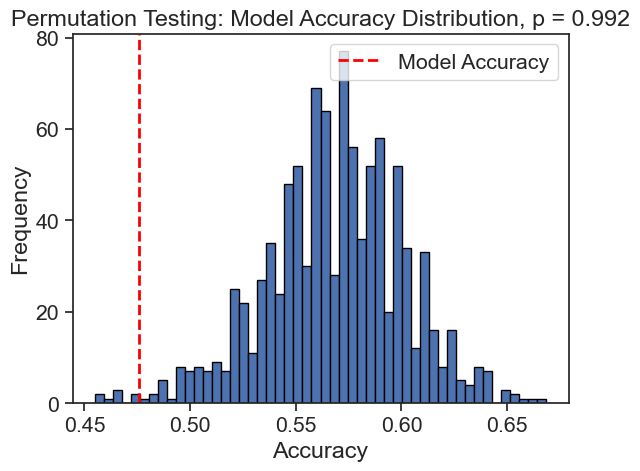

In [20]:
# build model with lasso selected features
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)







# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in tqdm(range(num_permutations)):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {round(p, 3)}')
plt.legend()

plt.show()

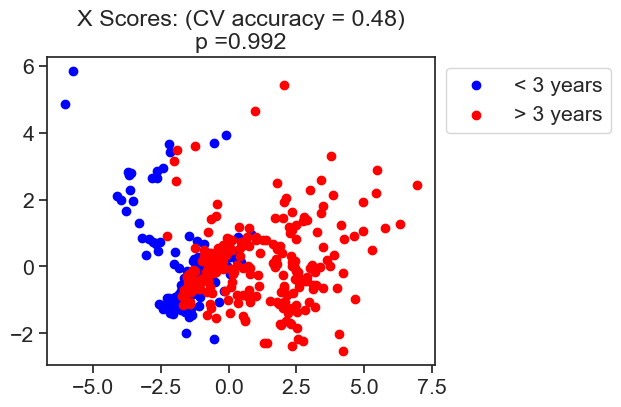

In [21]:
# plot X scores
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho'])
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='< 3 years')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='> 3 years')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel('LV1 (X_var = 64%, Yvar = 51%)')
#plt.ylabel('LV2 (X_var = 11%, Yvar = 0%)')
plt.legend(bbox_to_anchor = (1,1))

plt.show()


Text(0.5, 1.0, 'VIPs for oPLSDA model')

<Figure size 400x600 with 0 Axes>

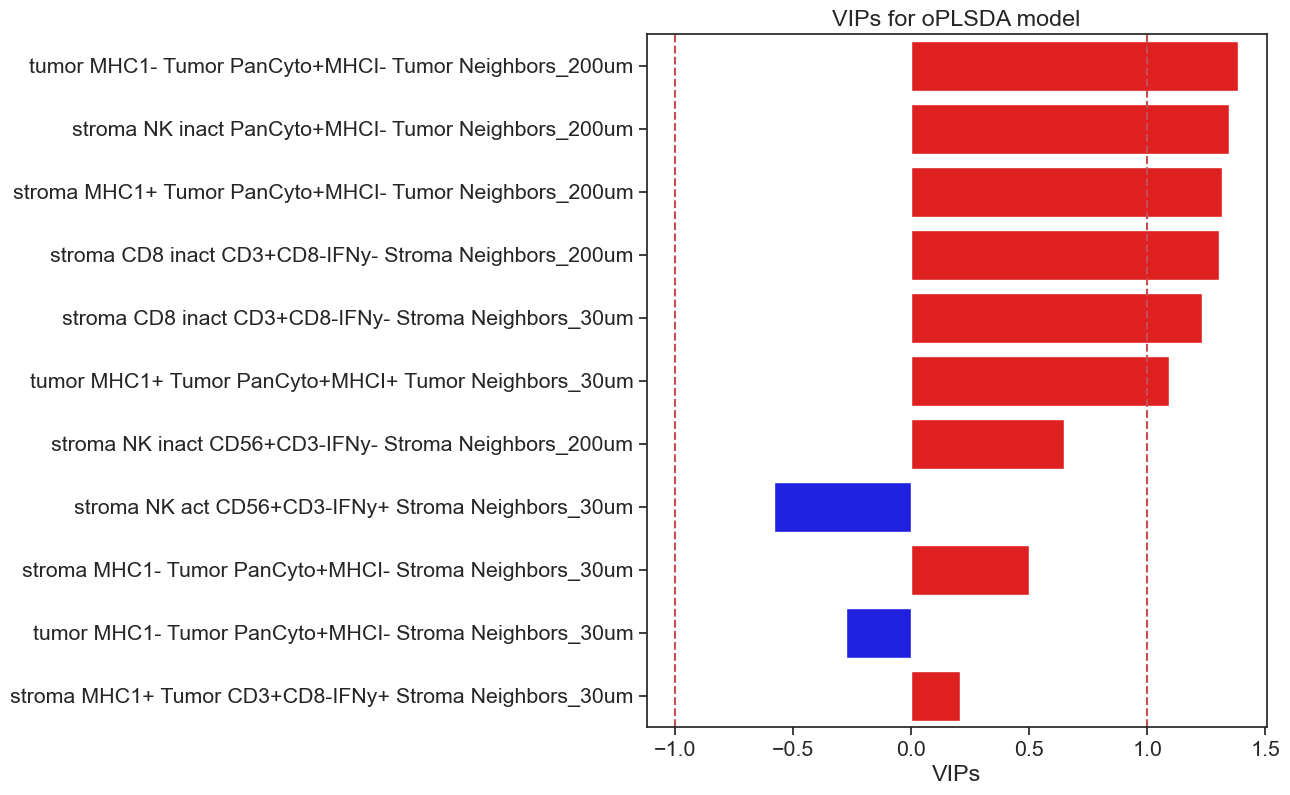

In [23]:
# Plot VIPs
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 
plt.figure(figsize=(8, 9)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] < 0, '> 3 years', '< 3 years')
colors = {'< 3 years': 'red', '> 3 years': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')

plt.title('VIPs for oPLSDA model')

In [24]:
neighbors_cv = processed_accuracy_rounded

# Both neighbor and counts

In [41]:
# reload the full dataset
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)


In [42]:
# lasso select the features

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from scipy import stats
from scipy.stats import zscore 

y_str = X['survival group']
X = X.drop(columns=['survival group', 'patient'])
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
X = X.fillna(0)
X = stats.zscore(X, ddof = 1)
#X = np.log1p(X)


#z_score_x = zscore(X.astype(float), axis = 1, ddof=1)

# parameters to be tested on GridSearchCV


# Number of Folds and adding the random state for replication

# Initializing the Model
lassocv = LassoCV(alphas=[1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1],cv = 10)


# GridSearchCV with model, params and folds.
lassocv.fit(X,y)
lasso_feat = lassocv.coef_
selected_features = np.array(X.columns)[lasso_feat != 0]
lasso_selected_x = X.loc[:,X.columns.isin(selected_features)]

# warnings can be supressed by increasing n_iter

/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+00, tolerance: 3.046e-02
  model = cd_fast.enet_coordinate_descent(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.729e+00, tolerance: 3.046e-02
  model = cd_fast.enet_coordinate_descent(
/home/gh8sj/.conda/envs/spy_cell/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

In [43]:
# print alpha and number of features
print(lassocv.alpha_, sum(x != 0 for x in lassocv.coef_))

0.1 11


In [44]:
# load data again and subset to the lasso selected features
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)

# filter to the lasso selected features
X = X.fillna(0)
X = X.loc[:,X.columns.isin(selected_features)]
X['survival group'] = y_str

X


,tumor Number of CD8s,tumor Tumor cell MHC1+ %,tumor MHC1+ Tumor PanCyto+MHCI+ Tumor Neighbors_30um,tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um,stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um,stroma NK act CD56+CD3-IFNy+ Stroma Neighbors_30um,stroma NK inact CD56+CD3-IFNy- Stroma Neighbors_200um,stroma NK inact PanCyto+MHCI+ Stroma Neighbors_200um,stroma NK inact PanCyto+MHCI- Tumor Neighbors_200um,stroma MHC1+ Tumor CD3+CD8-IFNy- Stroma Neighbors_200um,stroma MHC1+ Tumor PanCyto+MHCI- Tumor Neighbors_200um,survival group
"17-199_[43424,7543]",14.0,1.000000,0.098800,0.000000,0.641256,0.466625,0.536429,0.111810,0.000000,0.418354,0.000000,< 3 years
"17-199_[43424,9043]",228.0,1.000000,0.049196,0.000000,0.509025,0.000000,0.337555,0.138332,0.000000,0.421883,0.000000,< 3 years
"17-199_[44446,10543]",1094.0,0.996696,0.024454,0.671127,0.463989,0.000000,0.324533,0.180124,0.008614,0.454901,0.038381,< 3 years
"17-199_[44675,12043]",438.0,1.000000,0.069230,0.000000,0.664667,0.466625,0.555214,0.129063,0.000000,0.417773,0.000000,< 3 years
"17-199_[45431,7543]",40.0,0.974359,0.062865,0.834750,0.313793,0.000000,0.336665,0.062711,0.041009,0.256325,0.000000,< 3 years
...,...,...,...,...,...,...,...,...,...,...,...,...
"17-536_[47032,15356]",84.0,0.437700,0.201946,1.494037,1.655435,0.000000,0.423515,0.515095,1.139028,1.605682,1.101909,> 3 years
"17-536_[47032,16856]",40.0,0.464430,0.184300,1.410250,1.895530,0.000000,0.000000,0.562816,1.580742,1.757106,1.158856,> 3 years
"17-536_[49039,10345]",34.0,0.233633,0.068563,1.530029,0.607863,0.000000,0.162779,0.325899,0.946121,0.537709,1.347330,> 3 years
"17-536_[49039,11845]",42.0,0.236631,0.060644,1.305532,0.471891,0.000000,0.215565,0.335659,1.193093,0.378951,1.111453,> 3 years


100%|██████████| 1000/1000 [00:04<00:00, 238.75it/s]


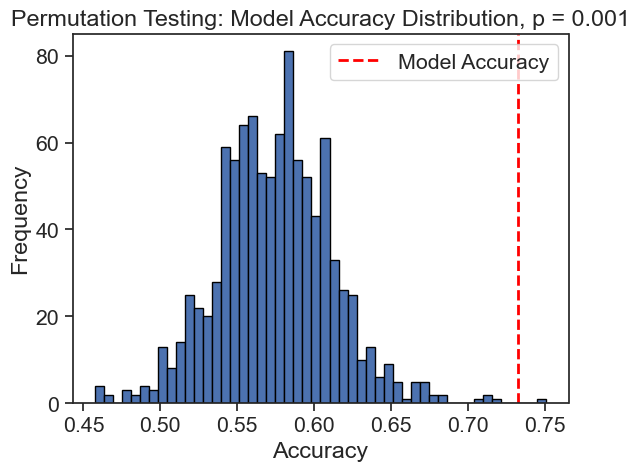

In [45]:
# build model with lasso selected features
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)


y_str = X['survival group']
X = X.drop(columns=['survival group'])
X = X.loc[:,X.columns.isin(selected_features)]
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
X





# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in tqdm(range(num_permutations)):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {round(p, 3)}')
plt.legend()

plt.show()

In [46]:
# save CV accuracy
both_cv = processed_accuracy_rounded

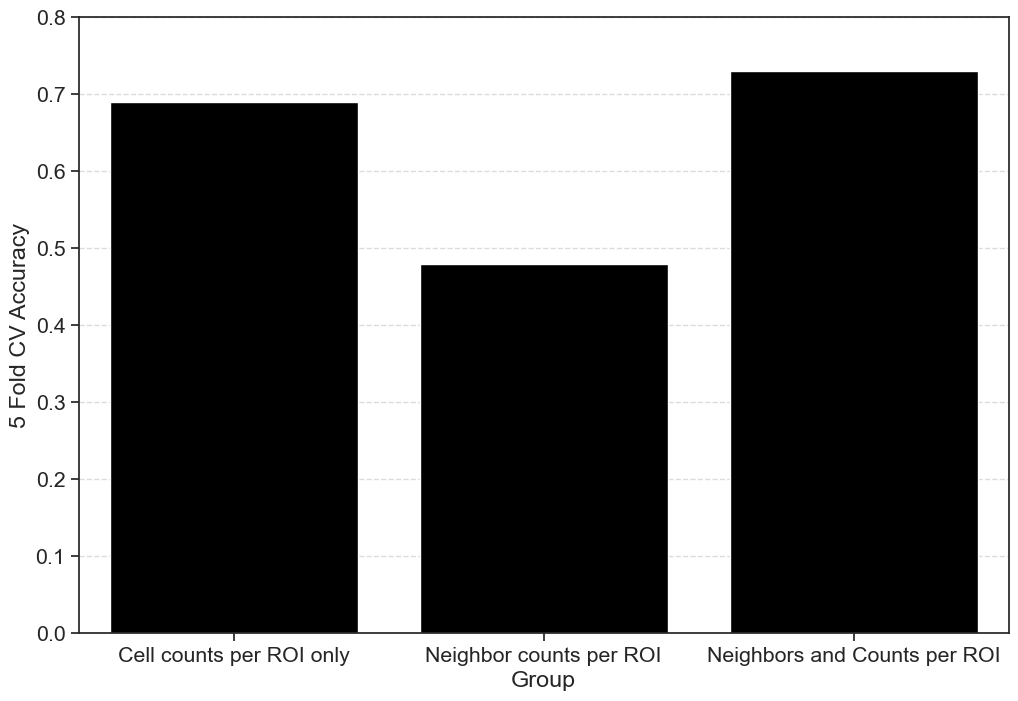

In [47]:
# plot a bar plot of the CV accuracy of the 3 models for editing in illustrator
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Define data
data = {
    'Group': ['Cell counts per ROI only', 'Neighbor counts per ROI', 'Neighbors and Counts per ROI'],
    'Accuracy': [counts_cv, neighbors_cv, both_cv]  # Replace with actual float values
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Explicitly set categorical order
df['Group'] = pd.Categorical(df['Group'], categories=[
    'Cell counts per ROI only', 
    'Neighbor counts per ROI', 
    'Neighbors and Counts per ROI'
], ordered=True)

# Sort DataFrame by the categorical order
df = df.sort_values('Group')

# Create dot plot
plt.figure(figsize=(12, 8))
sns.barplot(y = df['Accuracy'], x = df['Group'], color='black')  # Black dots, size=100
plt.ylim(0,0.8)
# Add labels
plt.ylabel("5 Fold CV Accuracy")

# Improve aesthetics
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add dashed grid lines on x-axis

plt.show()


<Figure size 800x600 with 0 Axes>

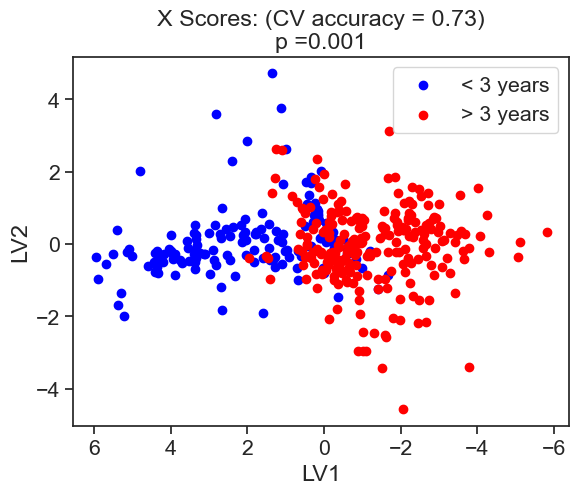

In [52]:
# plot the scores plot for the combined model



import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(8, 6)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
fig, ax = plt.subplots()
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='< 3 years')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='> 3 years')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
#plt.xlabel(f'PC1 X_var explained = {round(np.var(df.iloc[:,0])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.xlabel('LV1')
#plt.ylabel(f'PC2 X_var explained = {round(np.var(df.iloc[:,1])/sum(np.var(df.iloc[:,:], axis = None)), 3)}')
plt.ylabel('LV2')
plt.legend(bbox_to_anchor = (1,1))
ax.invert_xaxis()
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7c_scores.pdf',format='pdf', bbox_inches = 'tight')
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/fig6c.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

Text(0.5, 1.0, 'VIPs for oPLSDA model')

<Figure size 400x600 with 0 Axes>

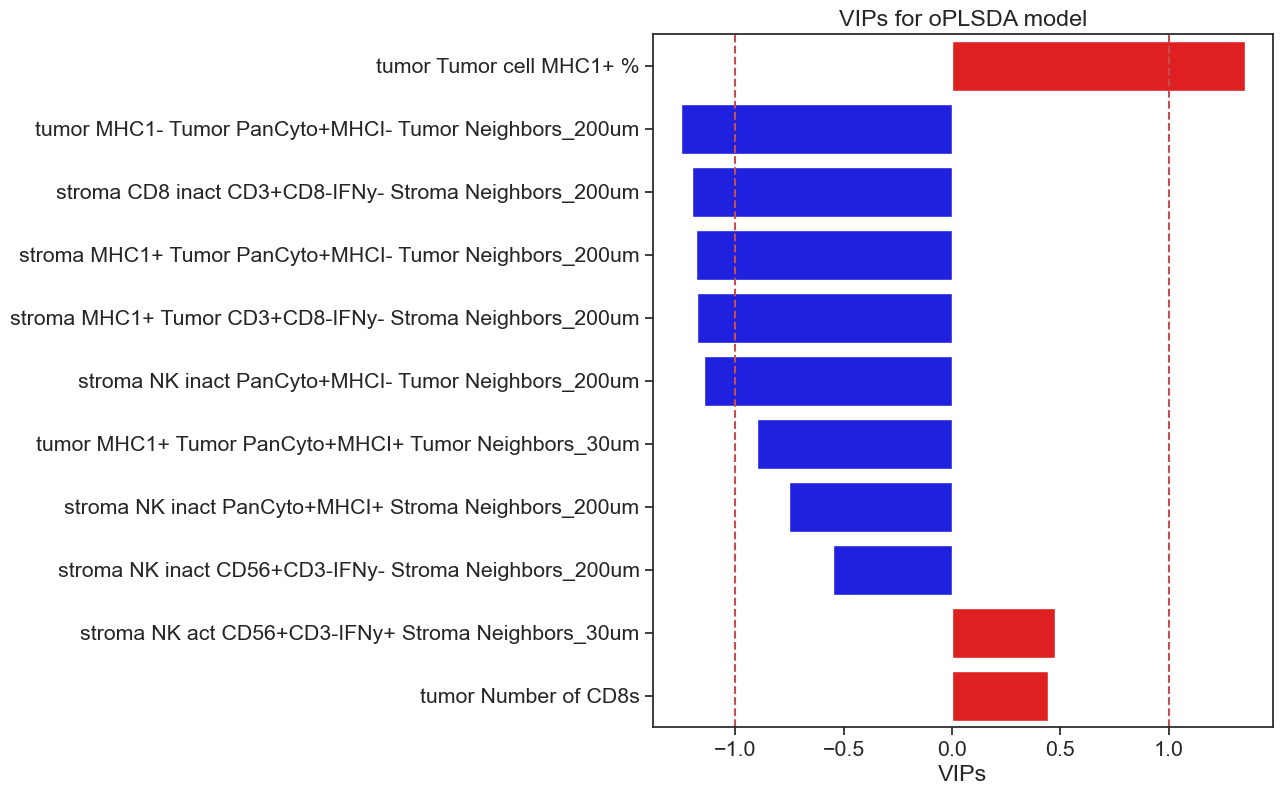

In [53]:
# VIPS for the combined model
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 
plt.figure(figsize=(8, 9)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] < 0, '> 3 years', '< 3 years')
colors = {'< 3 years': 'red', '> 3 years': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
plt.title('VIPs for oPLSDA model')